# CARTOON CLASSIFICATION
**Introduction**-: 

Welcome to the CARTOON CLASSIFICATION notebook! In this notebook, we will be exploring the identification of characters from the popular TV show "The Simpsons" using deep learning. We will be using the Kaggle Simpsons Characters Data, a collection of images of various characters from the show, to train and test our model.

Our approach to this problem will be using the ResNet18 algorithm, which is a popular deep learning architecture for image classification tasks. Specifically, we will be using the Torchvision library in PyTorch to implement and train our ResNet18 model on the Simpsons dataset.

Through this notebook, we hope to provide an intuitive and hands-on approach to image classification using deep learning, while also having some fun with the beloved characters from "The Simpsons". Let's get started!

## Installing required packages

In [ ]:
# Installing pytorch
!pip install torch

## Collecting Data

In [ ]:
# Upload your Kaggle API credentials to your Colab environment
from google.colab import files
files.upload() 
# Move the Kaggle API credentials to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Kaggle dataset
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

# Extract the contents of the ZIP file
!unzip the-simpsons-characters-dataset.zip

## Importing required packages

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import warnings
warnings.filter_warning('ignore')


## Loading & pre-processing data

In [ ]:
# Define image transformations
transform = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
     ])

# Define hyperparameters
batch_size = 32
num_epochs = 15
learning_rate = 0.001
momentum = 0.9

# device GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load training dataset
train_data = torchvision.datasets.ImageFolder(root='/content/simpsons_dataset', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Create dataloaders for training and validation data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load test dataset
test_data = torchvision.datasets.ImageFolder(root='/content/kaggle_simpson_testset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Get the class labels from the training dataset
classes = train_dataset.dataset.classes


## Display few samples

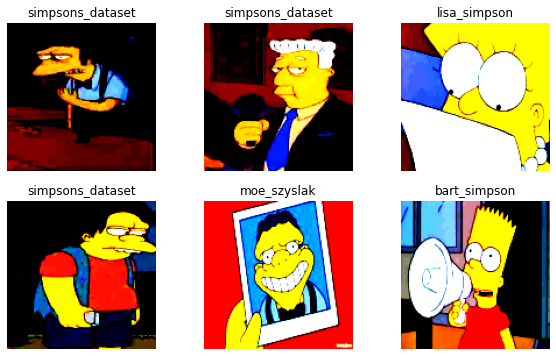

In [ ]:
# Define a function to display an image from the dataset
def show_image(image, label):
    plt.imshow(image.permute(1, 2, 0))
    plt.title(classes[label])
    plt.axis('off')

# Initialize a figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Loop through the trainset and display 6 images
for i in range(6):
    # Get the image and label
    image, label = train_dataset[i]
    
    # Calculate the row and column indices
    row = i // 3
    col = i % 3
    
    # Display the image in the corresponding subplot
    axs[row, col].imshow(image.permute(1, 2, 0))
    axs[row, col].set_title(classes[label])
    axs[row, col].axis('off')

# Show the plot
plt.show()


## Model

In [ ]:
# Define the model
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

# Define the loss function and optimizer
loss_ftn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# Move model to GPU if available
model.to(device)

# Train the model
train_losses, val_losses = [], []

# Initialize the progress bar
progress_bar = tqdm(range(num_epochs))

for epoch in range(num_epochs):
    # Train
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_ftn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_ftn(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Display training loss in the progress bar
    progress_bar.set_postfix_str(f'training loss: {train_loss:.3f} - validation loss: {val_loss:.3f}')

    # Update the progress bar
    progress_bar.update(1)


In [ ]:
# Plot the train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

## Model Evaluation

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Loop through the test data and make predictions
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        pred_labels += predicted.cpu().numpy().tolist()

# Generate the classification report
print(classification_report(true_labels, pred_labels, target_names=classes))

## Model prediction

In [ ]:
# Load an image
image, _ = train_dataset[0]

# Move the input tensor to the GPU
image = image.to(device)

# Display the image
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Make a prediction
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)

# Print the predicted class
print('Predicted class:', classes[predicted.item()])


## Saving the model

In [ ]:
# Save the model
torch.save(model.state_dict(), 'simpsons_resnet18.pth')

## Conclusion
In conclusion, the CARTOON CLASSIFICATION notebook aims to explore the identification of characters from "The Simpsons" TV show using deep learning. The notebook uses the ResNet18 algorithm, a popular deep learning architecture for image classification tasks, implemented using the Torchvision library in PyTorch to train and test the model on the Simpsons dataset. However, the results here are not promising and need further exploration and improvement. Overall, the notebook provides an opportunity to explore image classification using deep learning in a fun and engaging way, using characters from a popular TV show.